In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import confusion_matrix, classification_report # classification metrics
from imblearn.over_sampling import SMOTE # SMOTE
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler # scaling methods
from sklearn.metrics import recall_score,f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV # grid search cross validation
from sklearn.model_selection import RandomizedSearchCV # randomized search cross validation
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbbors
from sklearn.naive_bayes import GaussianNB # Gaussain Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import AdaBoostClassifier # Adaptive Boosting Classifier
from sklearn.ensemble import BaggingClassifier # Bootstrap Aggregating Classifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV # grid search cross validation
from sklearn.model_selection import RandomizedSearchCV # randomized search cross validation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

In [2]:
fraud=pd.read_csv('fraudTrain.csv')

In [3]:
fraud.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
#fraud.info()
#fraud.isna().sum()
#fraud.nunique()
#fraud.head(2)
fraud1=fraud.copy()

In [5]:
#Lets Drop Date and Time column and all other irrelavant columns!
fraud1.drop(['trans_date_trans_time','unix_time'], axis=1,inplace=True)
fraud1.drop(['first', 'last', 'street','dob', 'trans_num'],axis=1,inplace=True)
fraud1.drop(['lat','long'],axis=1,inplace=True)
fraud1.drop(['merch_lat','merch_long'],axis=1,inplace=True)
fraud1.drop(['city_pop'],axis=1,inplace=True)

In [6]:
fraud1.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'city', 'state',
       'zip', 'job', 'is_fraud'],
      dtype='object')

## Lets encode the categorical features now!

In [7]:
# Binarizing Gender column
def gender_binarizer(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
    
fraud1['gender'] = fraud1['gender'].transform(gender_binarizer)

In [8]:
fraud1['cc_num']=fraud1['cc_num'].astype(str)

In [9]:
fraud1['zip']=fraud1['zip'].astype(str)

## Lets find other categorical features and mean encode them!

In [10]:
c_feat=fraud1.loc[:,fraud1.dtypes==np.object].columns
c_feat

Index(['cc_num', 'merchant', 'category', 'city', 'state', 'zip', 'job'], dtype='object')

In [11]:
#mean-encode
for i in c_feat:
    mean =fraud1.groupby([i])['is_fraud'].mean()
    fraud1[i]=fraud1[i].map(mean)

In [12]:
fraud1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   cc_num    1296675 non-null  float64
 1   merchant  1296675 non-null  float64
 2   category  1296675 non-null  float64
 3   amt       1296675 non-null  float64
 4   gender    1296675 non-null  int64  
 5   city      1296675 non-null  float64
 6   state     1296675 non-null  float64
 7   zip       1296675 non-null  float64
 8   job       1296675 non-null  float64
 9   is_fraud  1296675 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 98.9 MB


In [13]:
X=fraud1.drop('is_fraud',axis=1)
y=fraud1['is_fraud']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)

## Since all but amount(amt) columns are pretty much on the same scale, we will normalize the amt variable!

In [15]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [16]:
sc.fit(np.array(X_train['amt']).reshape(-1,1))

StandardScaler()

In [17]:
X_train['amt']=sc.transform(np.array(X_train['amt']).reshape(-1,1))
X_test['amt']=sc.transform(np.array(X_test['amt']).reshape(-1,1))

<ipython-input-17-380b7b4b440b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['amt']=sc.transform(np.array(X_train['amt']).reshape(-1,1))
<ipython-input-17-380b7b4b440b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['amt']=sc.transform(np.array(X_test['amt']).reshape(-1,1))


### Apply SMOTE to the training Data!

In [18]:
#We'll apply SMOTE to the training data only
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns

In [19]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Feature Selection

### Lets check the importance of all the features in our data(by using ExtraTreeClassifier)!

#### Information Gain Method!

[0.07361741 0.10785788 0.18513066 0.33761755 0.01225602 0.0965985
 0.0431667  0.09796841 0.04578687]


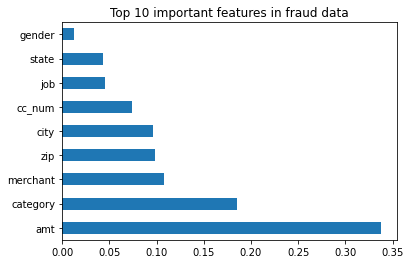

In [20]:
fs1 = ExtraTreesClassifier(n_jobs=-1)
fs1.fit(X_train,y_train)
print(fs1.feature_importances_) 
feat_importances1 = pd.Series(fs1.feature_importances_, index=X_train.columns)
feat_importances1.nlargest(10).plot(kind='barh')
plt.title("Top 10 important features in fraud data")
plt.show()

#### Forward Selection Method (Wrapper Based Method)!

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

##### We will use a logistic regression model as a base model to select the variables through Forward Selection Method! 

In [22]:
Base=LogisticRegression()

In [23]:
#Build step forward feature selection
sfs1 = sfs(Base,
           k_features=9,
           forward=True,
           floating=False,
           verbose=2,
           scoring='f1',
           cv=5,
           n_jobs=-1)
features=X.columns

In [24]:
sfs1.fit(X_train,y_train,custom_feature_names=features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.5s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.6s finished

[2021-06-10 12:25:36] Features: 1/9 -- score: 0.8392018365657637[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   30.8s remaining:   51.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   36.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   36.3s finished

[2021-06-10 12:26:12] Features: 2/9 -- score: 0.8579511439732344[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   31.7s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   45.0s finished

[2021-06-10 12:26:58] F

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=9,
                          n_jobs=-1, scoring='f1', verbose=2)

In [25]:
results=pd.DataFrame(sfs1.subsets_).T

In [26]:
results.drop('cv_scores', axis=1)

,feature_idx,avg_score,feature_names
1,"(3,)",0.839202,"(amt,)"
2,"(0, 3)",0.857951,"(cc_num, amt)"
3,"(0, 2, 3)",0.858474,"(cc_num, category, amt)"
4,"(0, 2, 3, 5)",0.859039,"(cc_num, category, amt, city)"
5,"(0, 2, 3, 4, 5)",0.859291,"(cc_num, category, amt, gender, city)"
6,"(0, 2, 3, 4, 5, 6)",0.859252,"(cc_num, category, amt, gender, city, state)"
7,"(0, 2, 3, 4, 5, 6, 7)",0.859053,"(cc_num, category, amt, gender, city, state, zip)"
8,"(0, 2, 3, 4, 5, 6, 7, 8)",0.858974,"(cc_num, category, amt, gender, city, state, z..."
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",0.858872,"(cc_num, merchant, category, amt, gender, city..."


### We can clearly see that (cc_num, category, amt, gender, city) are giving the best f1-score!

## First we will do modelling on a reduced model!

In [27]:
X_trainred=X_train[['cc_num', 'category', 'amt', 'gender', 'city']]
X_testred=X_test[['cc_num', 'category', 'amt', 'gender', 'city']]

In [28]:
classifier_names = ["Logistic Regression", "KNN", "Random Forest"]

classifiers = [LogisticRegression(n_jobs=-1), KNeighborsClassifier(n_jobs=-1), RandomForestClassifier(n_jobs=-1)]

final_clf = zip(classifier_names,classifiers)

In [29]:
def fit_classifier(pipeline, x_train, y_train, x_test, y_test):
    model_fit = pipeline.fit(x_train, y_train)
    y_pred = model_fit.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    confmatx=confusion_matrix(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    
    
    print("F1 score: {0:.4f}%".format(f1))
    
    print("Confusion Matrix/n", confmatx)
   
    
    #return f1,accuracy

In [30]:
def classifier(classifier, t_train, c_train, t_test, c_test):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([                         
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_acc = fit_classifier(checker_pipeline, t_train, c_train, t_test,c_test)
        result.append((n,clf_acc))
    return result

In [31]:
classifier(final_clf,X_trainred,y_train, X_testred, y_test)

Validation result for Logistic Regression
LogisticRegression(n_jobs=-1)
accuracy score: 92.98%
F1 score: 0.1172%
Confusion Matrix/n [[299903  22389]
 [   366   1511]]
Validation result for KNN
KNeighborsClassifier(n_jobs=-1)
accuracy score: 97.28%
F1 score: 0.2600%
Confusion Matrix/n [[313817   8475]
 [   330   1547]]
Validation result for Random Forest
RandomForestClassifier(n_jobs=-1)
accuracy score: 99.47%
F1 score: 0.6392%
Confusion Matrix/n [[320920   1372]
 [   351   1526]]


[('Logistic Regression', None), ('KNN', None), ('Random Forest', None)]

In [32]:
model1=LogisticRegression(n_jobs=-1)
model1.fit(X_trainred,y_train)
probas_lr=model1.predict_proba(X_testred)

In [33]:
model2=KNeighborsClassifier(n_jobs=-1)
model2.fit(X_trainred,y_train)
probas_knn=model2.predict_proba(X_testred)

In [34]:
model3=RandomForestClassifier(n_jobs=-1)
model3.fit(X_trainred,y_train)
probas_rf=model3.predict_proba(X_testred)

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score,auc

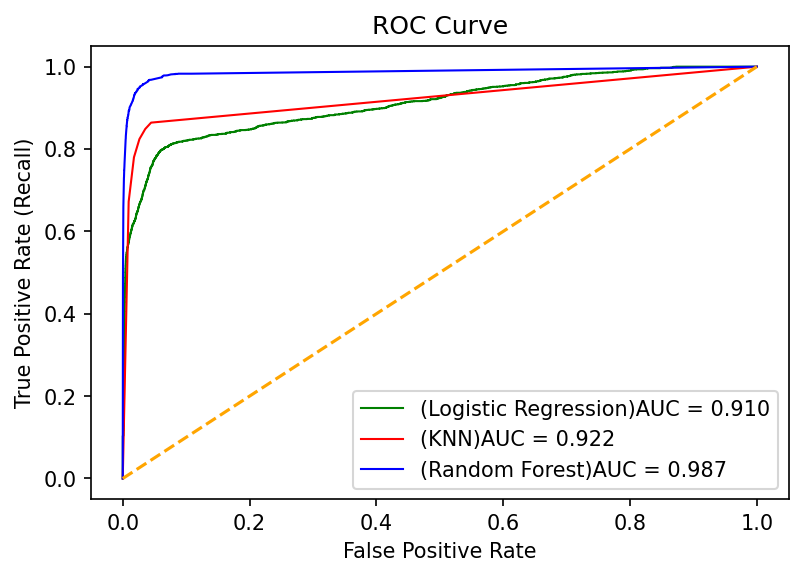

In [36]:
# get false and true positive rates
fpr1, tpr1, thresholds1 = roc_curve(y_test, probas_lr[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probas_knn[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probas_rf[:,1], pos_label=1)

# get area under the curve
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr1, tpr1, lw=1, color='green', label=f'(Logistic Regression)AUC = {roc_auc1:.3f}')
plt.plot(fpr2, tpr2, lw=1, color='red', label=f'(KNN)AUC = {roc_auc2:.3f}')
plt.plot(fpr3, tpr3, lw=1, color='blue', label=f'(Random Forest)AUC = {roc_auc3:.3f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

 # plot some thresholds
#thresholdsLength = len(thresholds1)
#colorMap=plt.get_cmap('jet', thresholdsLength)
#for i in range(0, thresholdsLength, 5000):
    #threshold_value_with_max_four_decimals = str(thresholds1[i])[:5]
    #plt.text(fpr1[i] - 0.03, tpr1[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 5}, color=colorMap(i/thresholdsLength));
plt.show()

### ROC Curve for Random Forest Only

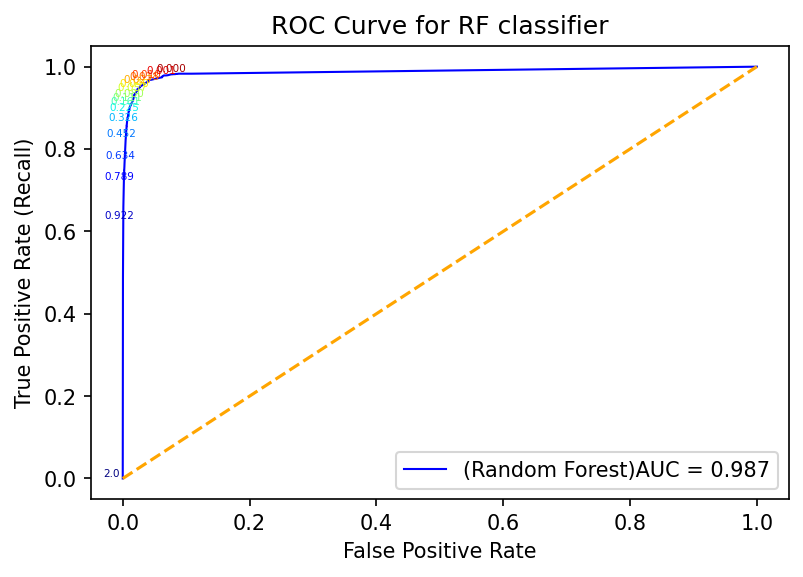

In [37]:
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr3, tpr3, lw=1, color='blue', label=f'(Random Forest)AUC = {roc_auc3:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

 # plot some thresholds
thresholdsLength = len(thresholds3)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, 100):
    threshold_value_with_max_four_decimals = str(thresholds3[i])[:5]
    plt.text(fpr3[i] - 0.03, tpr3[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 5}, color=colorMap(i/thresholdsLength));
plt.show()

In [38]:
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
random_forest.fit(X_trainred, y_train)

threshold = 0.025

predicted = random_forest.predict_proba(X_testred)

In [39]:
from sklearn.metrics import precision_score, recall_score

In [40]:
pred=[]
for i in range(len(predicted)):
    if predicted[:,1][i] >= threshold:
        pred.append(1)
    else:
        pred.append(0)

In [41]:
confusion_matrix(y_test,pred)

array([[312022,  10270],
       [    81,   1796]], dtype=int64)

In [42]:
recall_score(y_test,pred,pos_label=1)

0.9568460309003729

In [43]:
precision_score(y_test,pred,pos_label=1)

0.14884800265208023

### Lets train the full model for Random Forest only as it was performing the best!

In [44]:
Random_forest_fullm=RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [45]:
Random_forest_fullm.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [46]:
full_modpred=Random_forest_fullm.predict(X_test)

In [47]:
probas_fullmod=Random_forest_fullm.predict_proba(X_test)

In [48]:
confusion_matrix(y_test,full_modpred)

array([[321689,    603],
       [   404,   1473]], dtype=int64)

In [49]:
fpr_fm, tpr_fm, thresholds_fm = roc_curve(y_test, probas_fullmod[:,1], pos_label=1)

# get area under the curve
roc_auc_fm = auc(fpr_fm, tpr_fm)

### ROC curve for full Random Forest Model.

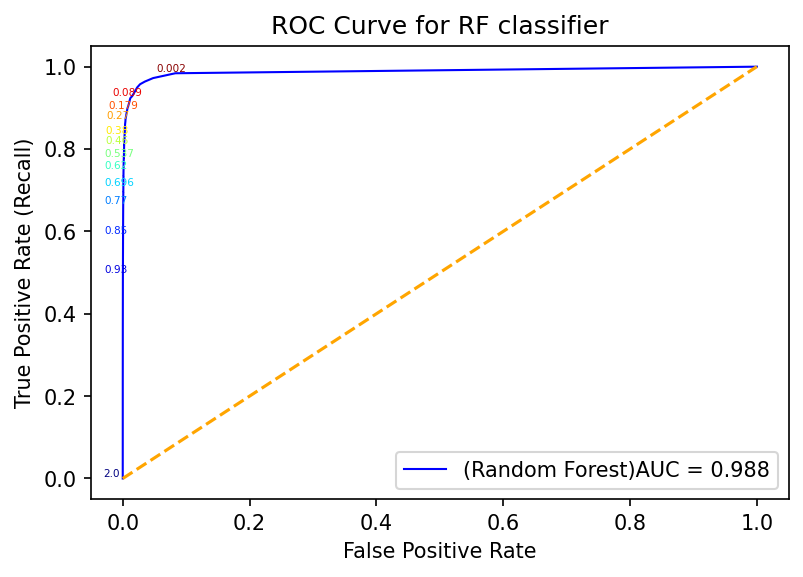

In [50]:
plt.figure(dpi=150)
plt.plot(fpr_fm, tpr_fm, lw=1, color='blue', label=f'(Random Forest)AUC = {roc_auc_fm:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

 # plot some thresholds
thresholdsLength = len(thresholds_fm)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, 10):
    threshold_value_with_max_four_decimals = str(thresholds_fm[i])[:5]
    plt.text(fpr_fm[i] - 0.03, tpr_fm[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 5}, color=colorMap(i/thresholdsLength));
plt.show()

In [51]:
predfm=[]
for i in range(len(probas_fullmod)):
    if probas_fullmod[:,1][i] >= 0.125:
        predfm.append(1)
    else:
        predfm.append(0)

In [52]:
confusion_matrix(y_test,predfm)

array([[319319,   2973],
       [   173,   1704]], dtype=int64)

### Lets fine tune the HyperParameters using GridSearchCV and RandomSearchCV!

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
gridfm=GridSearchCV(RandomForestClassifier(n_estimators=50),param_grid={'max_depth':[5, 8, 15, 25, 30]},n_jobs=-1,scoring='f1',
                           cv=2)

In [55]:
finalm=RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [56]:
finalm.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [57]:
finalpred=finalm.predict(X_test)

In [58]:
probas_final=finalm.predict_proba(X_test)

In [59]:
confusion_matrix(y_test,finalpred)

array([[321704,    588],
       [   395,   1482]], dtype=int64)

In [60]:
fraudtest=pd.read_csv('fraudTest.csv')

In [61]:
fraudtest.drop('Unnamed: 0',axis=1,inplace=True)

In [62]:
fraudtest.drop(['trans_date_trans_time','unix_time'], axis=1,inplace=True)
fraudtest.drop(['first', 'last', 'street','dob', 'trans_num'],axis=1,inplace=True)
fraudtest.drop(['lat','long'],axis=1,inplace=True)
fraudtest.drop(['merch_lat','merch_long'],axis=1,inplace=True)
fraudtest.drop(['city_pop'],axis=1,inplace=True)

In [63]:
# Binarizing Gender column
def gender_binarizer(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
    
fraudtest['gender'] = fraudtest['gender'].transform(gender_binarizer)

In [64]:
fraudtest['cc_num']=fraudtest['cc_num'].astype(str)
fraudtest['zip']=fraudtest['zip'].astype(str)

In [65]:
#mean-encode
for i in c_feat:
    mean =fraudtest.groupby([i])['is_fraud'].mean()
    fraudtest[i]=fraudtest[i].map(mean)

In [66]:
X_t=fraudtest.drop('is_fraud',axis=1)
y_t=fraudtest['is_fraud']

In [67]:
X_t['amt']=sc.transform(np.array(X_t['amt']).reshape(-1,1))

In [68]:
ffpred=finalm.predict(X_t)

In [69]:
probas_ffpred=finalm.predict_proba(X_t)

In [70]:
confusion_matrix(y_t,ffpred)

array([[540147,  13427],
       [   479,   1666]], dtype=int64)

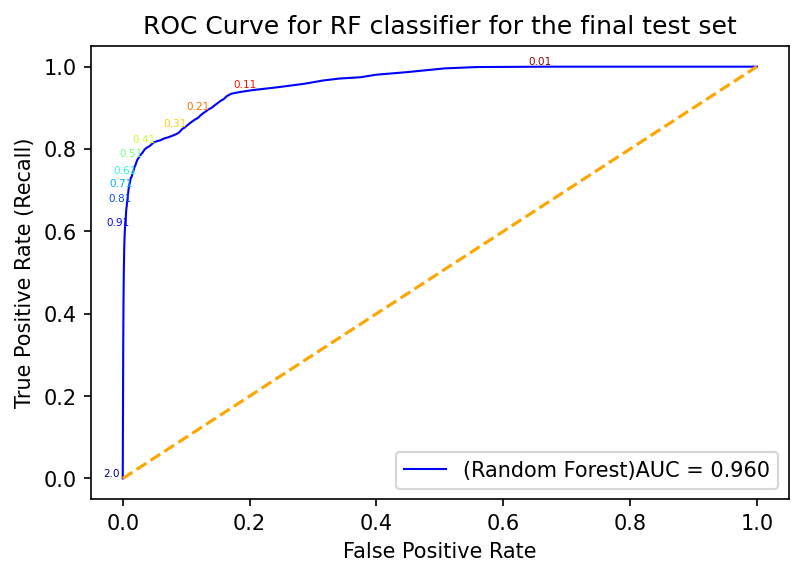

In [71]:
fpr_ff, tpr_ff, thresholds_ff = roc_curve(y_t, probas_ffpred[:,1], pos_label=1)

# get area under the curve
roc_auc_ff = auc(fpr_ff, tpr_ff)

plt.figure(dpi=150)
plt.plot(fpr_ff, tpr_ff, lw=1, color='blue', label=f'(Random Forest)AUC = {roc_auc_ff:.3f}')
plt.title('ROC Curve for RF classifier for the final test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()

 # plot some thresholds
thresholdsLength = len(thresholds_ff)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, 10):
    threshold_value_with_max_four_decimals = str(thresholds_ff[i])[:5]
    plt.text(fpr_ff[i] - 0.03, tpr_ff[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 5}, color=colorMap(i/thresholdsLength));
plt.show()

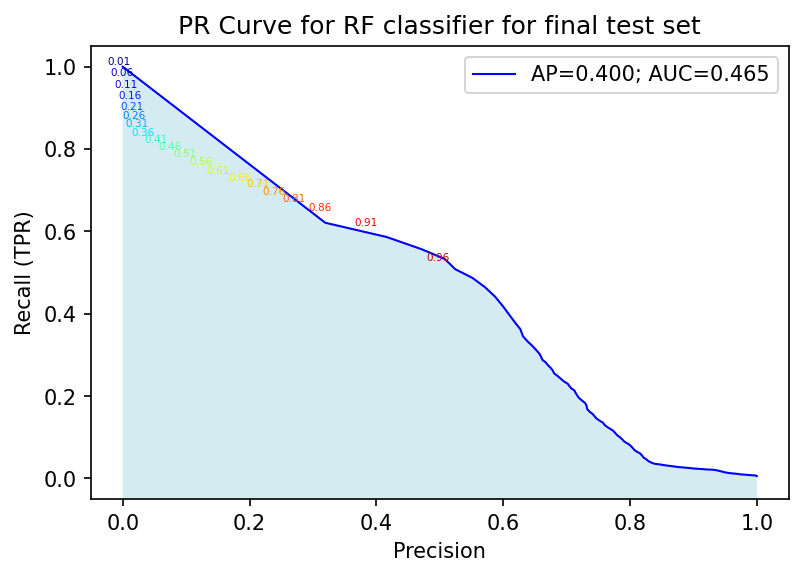

In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
# get precision and recall values
precision, recall, thresholds = precision_recall_curve(y_t, probas_ffpred[:,1], pos_label=1)
# average precision score
avg_precision = average_precision_score(y_t, probas_ffpred[:,1])
# precision auc
pr_auc = auc(recall, precision)
# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for RF classifier for final test set')
plt.xlabel('Precision')
plt.ylabel('Recall (TPR)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, 5):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(precision[i] - 0.03, recall[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 5}, color=colorMap(i/thresholdsLength));
plt.show()

In [73]:
predff=[]
for i in range(len(probas_ffpred)):
    if probas_ffpred[:,1][i] >=0.31:
        predff.append(1)
    else:
        predff.append(0)

In [74]:
finalcxm=confusion_matrix(y_t,predff)
finalcxm

array([[501534,  52040],
       [   324,   1821]], dtype=int64)

In [75]:
recall_score(y_t,predff)

0.848951048951049

In [76]:
precision_score(y_t,predff)

0.03380924973543009

## The precision in the prediction of our final model is pretty low but recall is really good. This does increase the number of False Positives but it is still within the range of 0.5% - 1%.

In [77]:
print(round((finalcxm[0][1]/(finalcxm.sum()))*100,2),"%")

9.36 %
